<a href="https://colab.research.google.com/github/Masoud-Ghasemian/PyTorch_Basics/blob/master/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)

cuda:0


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10('./data', train = True, 
                                        transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 4,
                                           shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10('./data', train = False,
                                       transform = transform, download = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False,
                                          num_workers = 2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Function to show an image

In [7]:
def imshow(img):
  img = img/2 + 0.5      #unnormalize images from range [-1, 1] to [0, 1]
  img = img.numpy()
  img = np.transpose(img, (1,2,0))   #transpose the image from 3*32*32 to 32*32*3
  plt.imshow(img)
  plt.show()

##Get some random images from train loader

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

##Show images

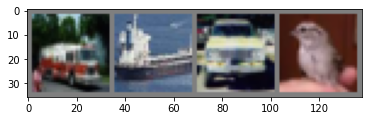


truck         ship         car         bird


In [9]:
imshow(torchvision.utils.make_grid(images))
print('         '.join(classes[labels[i]] for i in range(4)))

In [10]:
class Image_Classifier(nn.Module):
  def __init__(self):
    super(Image_Classifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Image_Classifier()
model = model.to(device)
print(model)

Image_Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
%%time
batch_size = 4
n_example = len(train_loader) * batch_size
for epoch in range(10):

  running_loss = 0.0
  num_correct = 0.0
  for i, data in enumerate(train_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(output, dim=1)
    num_correct += torch.sum(predicted == labels).double()

    running_loss += loss.item()
  print(f'epoch: {epoch+1}, loss: {running_loss/len(train_loader)}, accuracy: {num_correct/n_example}')

    

epoch: 1, loss: 1.7266072908473016, accuracy: 0.36278000000000005
epoch: 2, loss: 1.345235616402626, accuracy: 0.5171800000000001
epoch: 3, loss: 1.2046939162373542, accuracy: 0.5730200000000001
epoch: 4, loss: 1.107776725025177, accuracy: 0.6072200000000001
epoch: 5, loss: 1.03219135948658, accuracy: 0.6361
epoch: 6, loss: 0.969859390115738, accuracy: 0.6581400000000001
epoch: 7, loss: 0.9226026094436646, accuracy: 0.67498
epoch: 8, loss: 0.8848918426656723, accuracy: 0.68896
epoch: 9, loss: 0.8549855974149704, accuracy: 0.6993400000000001
epoch: 10, loss: 0.8215220088887215, accuracy: 0.70816
CPU times: user 6min 6s, sys: 36.5 s, total: 6min 42s
Wall time: 6min 50s


In [13]:
PATH = './Image_classifier.pth'
torch.save(model.state_dict(), PATH)

##Loading the model

In [14]:
#model = Image_Classifier()
#model.load_state_dict(torch.load(PATH))
#model = model.to(device)

## Test the network on the test data

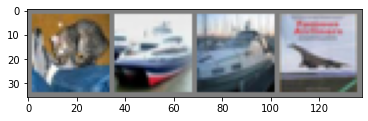

True:   cat      ship      ship      plane
Predicted: cat      ship      ship      plane


In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
images = images.to(device)
labels = labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, dim=1)

print('True:  ', '      '.join(classes[labels[i]] for i in range(4)))
print('Predicted:', '      '.join(classes[predicted[i]] for i in range(4)))

In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (labels == predicted).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1




In [19]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 77 %
Accuracy of  bird : 51 %
Accuracy of   cat : 34 %
Accuracy of  deer : 62 %
Accuracy of   dog : 57 %
Accuracy of  frog : 68 %
Accuracy of horse : 65 %
Accuracy of  ship : 76 %
Accuracy of truck : 68 %
